### **EDA**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud
import re
import unicodedata
import nltk
import csv
import string
from textblob import TextBlob
from nltk.corpus import stopwords
!pip install demoji
nltk.download('all')
import demoji

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Package brown_tei is already up-to-date!
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Package cess_cat is already up-to-date!
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Package cess_esp is already up-to-date!
[nltk_data]    | Downloading packag

In [ ]:
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
SEED = 1024
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchtext
from torchtext import data

import warnings
warnings.filterwarnings('ignore')
import operator

from sklearn.metrics import hamming_loss, jaccard_score, label_ranking_average_precision_score, f1_score
from tqdm._tqdm_notebook import tqdm_notebook as tqdm

In [ ]:
!git clone https://github.com/sydney-machine-learning/COVID19_sentinentanalysissocialmedia

fatal: destination path 'COVID19_sentinentanalysissocialmedia' already exists and is not an empty directory.


In [ ]:
demoji.download_codes()

... OK (Got response in 0.14 seconds)
Writing emoji data to /root/.demoji/codes.json ...
... OK


In [ ]:
senwave = pd.read_csv("/content/drive/My Drive/Covid 19 India/labeledEn.csv")
print("Length of Senwave Dataset = {}".format(len(senwave)))

Length of Senwave Dataset = 10000


In [ ]:
senwave.head(10)

,ID,Tweet,Optimistic,Thankful,Empathetic,Pessimistic,Anxious,Sad,Annoyed,Denial,Official report,Surprise,Joking
0,1.245140e+18,A glass of wine keeps the corona away- DRAKE. ...,1,0,0,0,0,0,0,0,0,0,1
1,1.245140e+18,Can Anyone tell me if you took the flu shot la...,0,0,0,0,1,0,0,0,0,1,0
2,1.245140e+18,Btw producers send me beats I’m working on mus...,1,0,0,0,0,0,0,0,0,0,1
3,1.245140e+18,When someone you know.. apart of your family d...,0,0,0,0,0,1,0,0,0,0,0
4,1.245140e+18,"Dear soccer,\nI really miss you ,please come b...",0,0,0,0,0,1,1,0,0,0,0
5,1.245140e+18,new home remedy to treat coronavirus! tested b...,1,0,0,0,0,0,0,1,0,0,1
6,1.245140e+18,When Xavier Wulf does an Attack on Titan tape ...,0,0,0,0,0,0,0,0,0,0,1
7,1.245140e+18,Mouthwash is hand san for your mouth and I don...,0,0,0,0,0,1,0,0,0,1,1
8,1.245140e+18,@Sandykikimunch2 @Thomas1774Paine Yes all of t...,0,0,0,0,0,0,1,0,1,1,0
9,1.245140e+18,Update I destroyed the tire 😔 honestly if I ge...,0,0,0,1,0,1,0,0,0,0,0


Text(0.5, 0, 'Count')

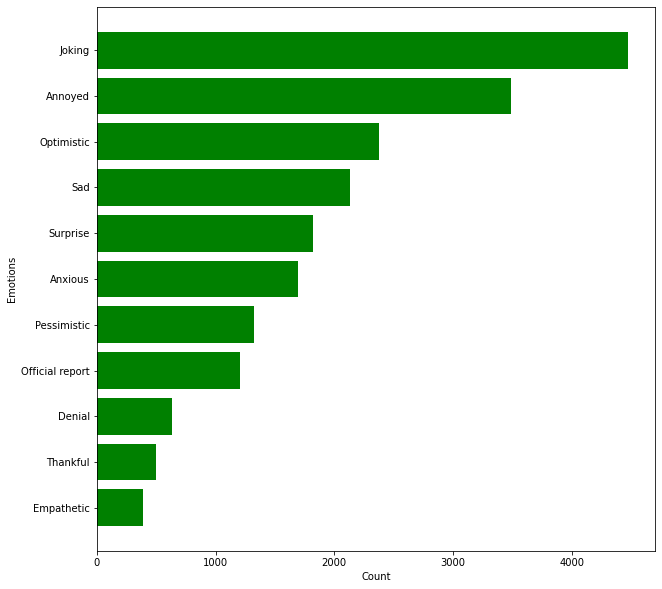

In [ ]:
emotions = list(senwave.columns[2:])
scores = [sum(senwave[x]) for x in emotions]
pairs = []

for i in range(len(emotions)):
    pairs.append((emotions[i], scores[i]))

pairs = sorted(pairs, key = lambda x : x[1], reverse = False)
emotions_sorted = []
scores_sorted = []

for pair in pairs:
    emotions_sorted.append(pair[0])
    scores_sorted.append(pair[1])

fig = plt.figure(figsize = (10, 10))
plt.barh(emotions_sorted, scores_sorted, color = 'green')
plt.ylabel("Emotions")
plt.xlabel("Count")

In [ ]:
rand_idx = np.random.randint(0, len(senwave))
print("Tweet : ", senwave.iloc[rand_idx]['Tweet'])
for e in emotions:
    print(e, ": ", senwave.iloc[rand_idx][e])

Tweet :  I remember when they warned us about corona virus but everyone was hurting over the death of Kobe 🤷🏾‍♀️
Optimistic :  0
Thankful :  0
Empathetic :  0
Pessimistic :  0
Anxious :  0
Sad :  1
Annoyed :  0
Denial :  0
Official report :  0
Surprise :  0
Joking :  0


In [ ]:
only_emotes = senwave[emotions]

In [ ]:
only_emotes

,Optimistic,Thankful,Empathetic,Pessimistic,Anxious,Sad,Annoyed,Denial,Official report,Surprise,Joking
0,1,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,1,0,0,0,0,1,0
2,1,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,1,0,0,0,0,0,0,0,0,0,1
9996,1,1,0,0,1,0,0,0,0,0,0
9997,0,0,0,0,0,0,0,0,0,1,0
9998,1,0,0,1,0,0,0,0,0,0,1


In [ ]:
only_emotes.iloc[0].tolist()

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]

In [ ]:
emote_array = np.zeros((11, 11))
e2i = {
    'Optimistic' : 0, 'Thankful' : 1, 'Empathetic' : 2, 'Pessimistic' : 3, 'Anxious' : 4, 'Sad' : 5, 'Annoyed' : 6, 'Denial' : 7, 'Official report' : 8,
    'Surprise' : 9, 'Joking' : 10
}
for i in range(len(only_emotes)):
    l = only_emotes.iloc[i].tolist()
    for j in range(11):
        if l[j] == 1:
            emote_array[j][j] += 1
        for k in range(j+1, 11):
            if (l[j] == 1) and (l[k] == 1):
                emote_array[j][k] += int(1)
                emote_array[k][j] += int(1)

In [ ]:
emote_df = pd.DataFrame(emote_array, columns = emotions)
for col in emote_df:
    emote_df[col] = emote_df[col].astype(int)
emote_df

,Optimistic,Thankful,Empathetic,Pessimistic,Anxious,Sad,Annoyed,Denial,Official report,Surprise,Joking
0,2373,235,171,226,246,291,379,72,156,387,982
1,235,498,28,15,41,29,67,14,70,98,92
2,171,28,389,18,50,71,41,7,7,24,63
3,226,15,18,1325,268,272,420,90,62,264,554
4,246,41,50,268,1695,360,452,95,138,357,510
5,291,29,71,272,360,2133,723,54,186,299,747
6,379,67,41,420,452,723,3492,261,122,536,1235
7,72,14,7,90,95,54,261,631,51,201,184
8,156,70,7,62,138,186,122,51,1207,284,95
9,387,98,24,264,357,299,536,201,284,1820,612


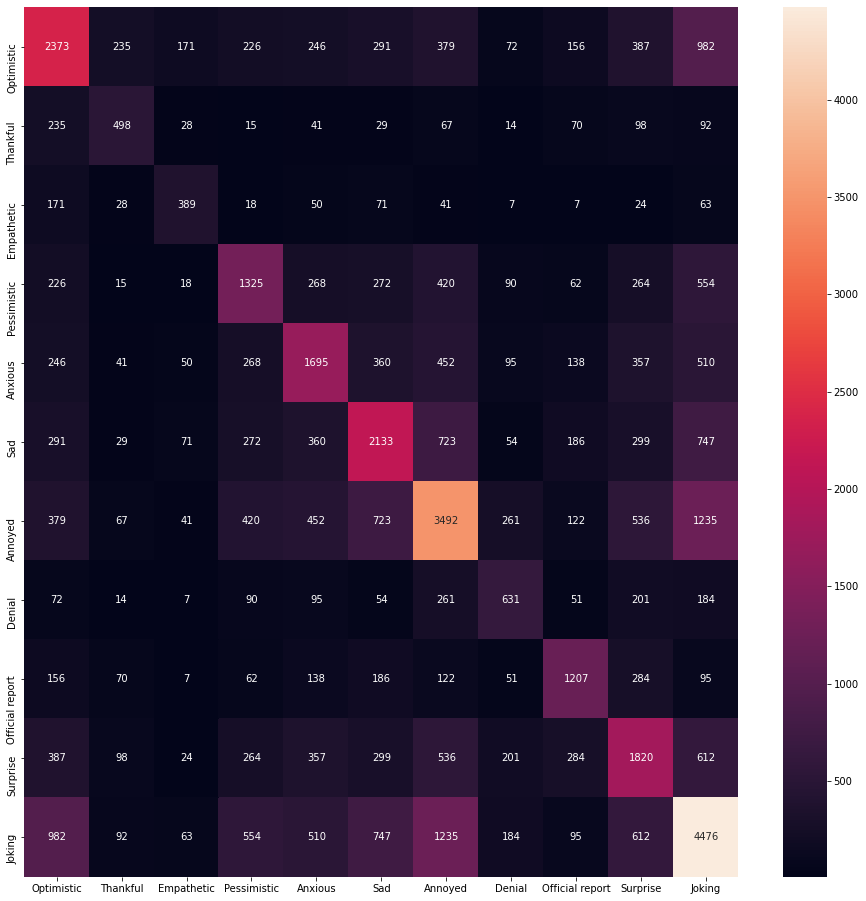

In [ ]:
fig = plt.figure(figsize = (16,16))
sns.heatmap(emote_df, annot = True, xticklabels = emote_df.columns, yticklabels = emote_df.columns, fmt = 'g')

Inferences:
*   We see that around 1000 people who were being optimistic also had a joke emotion attached to their tweet.
* Around 390 of the people who were being positive also had a surprise attached to their tweet. It could be probably because of some good news they weren't expecting.
* Pessimistic tweets usually were of joking nature or were displaying their annoyance.
*   When people were being thankful, it was usually towards the Government or God or People in general and therefore it made them optimistic for the future (about 240)
* About 1200 of the people who were annoyed were also joking. Displaying your annoyance through jokes never goes out of style.
* About 780 of the 2100 tweets which were sad were jokes, i.e. people were trying to drown their sadness through laughter.


**WORD CLOUDs**

**Optimism**

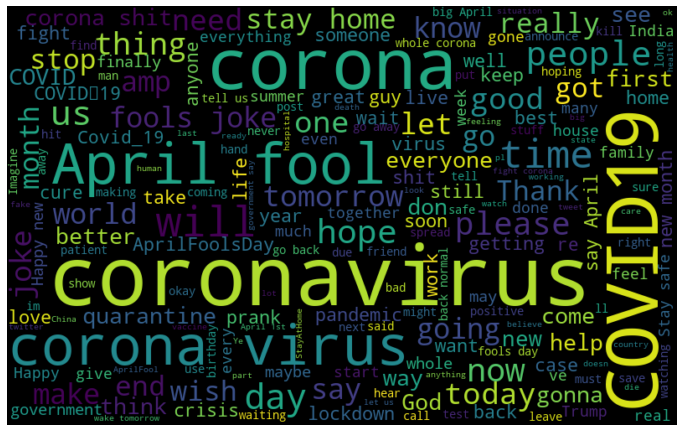

In [ ]:
optimisticWords = " ".join([word for word in senwave['Tweet'][senwave['Optimistic'] == 1]])
wc = WordCloud(width = 800, height = 500, max_font_size = 100).generate(optimisticWords)
plt.figure(figsize = (12, 8))
plt.imshow(wc, interpolation = 'bilinear')
plt.axis('off')
plt.show()

**Thankful**

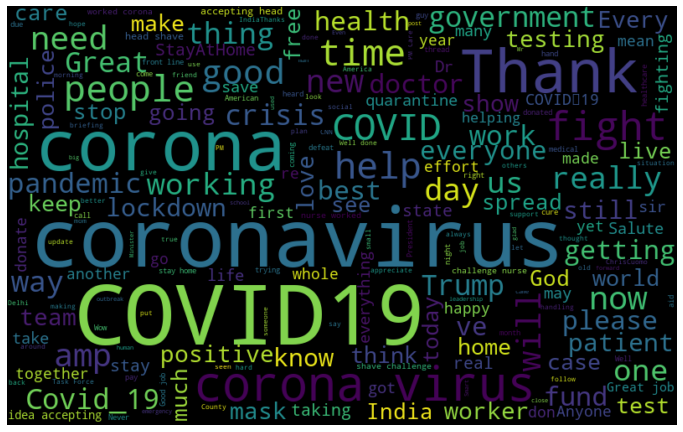

In [ ]:
thankfulWords = " ".join([word for word in senwave['Tweet'][senwave['Thankful'] == 1]])
wc = WordCloud(width = 800, height = 500, max_font_size = 100).generate(thankfulWords)
plt.figure(figsize = (12, 8))
plt.imshow(wc, interpolation = 'bilinear')
plt.axis('off')
plt.show()

**Empathy**

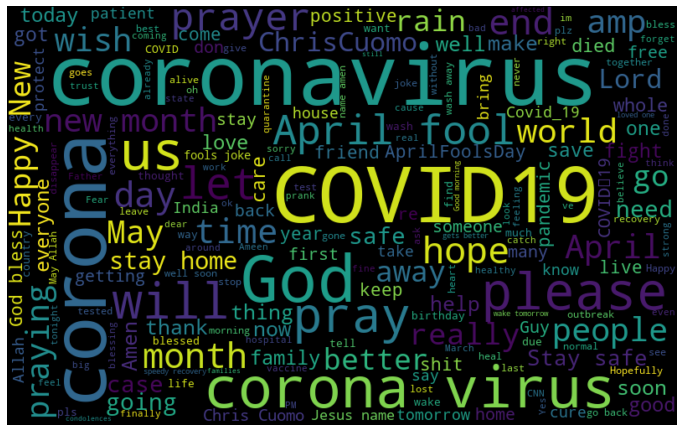

In [ ]:
empatheticWords = " ".join([word for word in senwave['Tweet'][senwave['Empathetic'] == 1]])
wc = WordCloud(width = 800, height = 500, max_font_size = 100).generate(empatheticWords)
plt.figure(figsize = (12, 8))
plt.imshow(wc, interpolation = 'bilinear')
plt.axis('off')
plt.show()

**Anxiety**

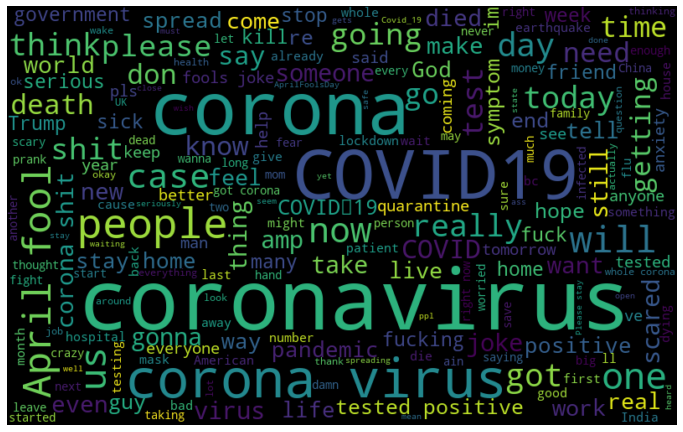

In [ ]:
anxiousWords = " ".join([word for word in senwave['Tweet'][senwave['Anxious'] == 1]])
wc = WordCloud(width = 800, height = 500, max_font_size = 100).generate(anxiousWords)
plt.figure(figsize = (12, 8))
plt.imshow(wc, interpolation = 'bilinear')
plt.axis('off')
plt.show()

**Sad**

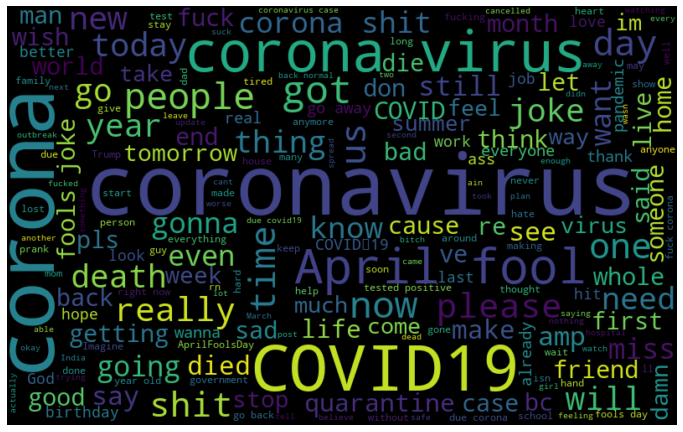

In [ ]:
sadWords = " ".join([word for word in senwave['Tweet'][senwave['Sad'] == 1]])
wc = WordCloud(width = 800, height = 500, max_font_size = 100).generate(sadWords)
plt.figure(figsize = (12, 8))
plt.imshow(wc, interpolation = 'bilinear')
plt.axis('off')
plt.show()

**Official Report**

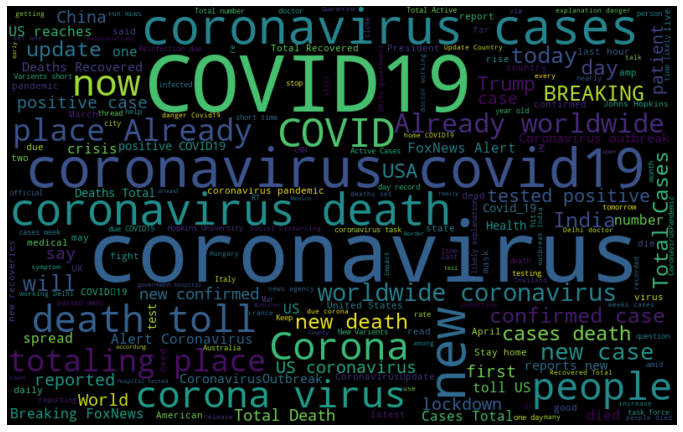

In [ ]:
ORWords = " ".join([word for word in senwave['Tweet'][senwave['Official report'] == 1]])
wc = WordCloud(width = 800, height = 500, max_font_size = 100).generate(ORWords)
plt.figure(figsize = (12, 8))
plt.imshow(wc, interpolation = 'bilinear')
plt.axis('off')
plt.show()

**Joking**

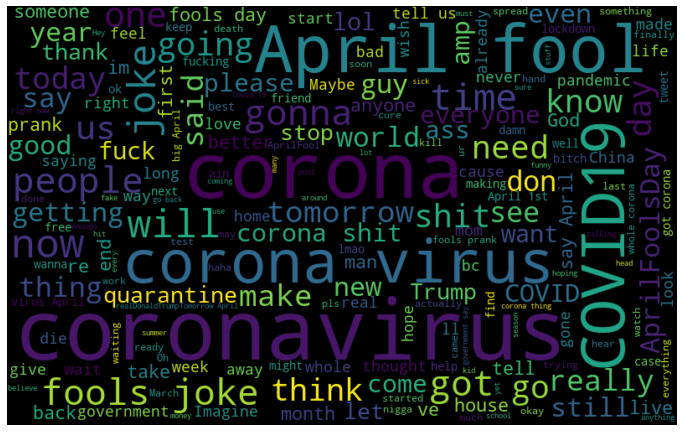

In [ ]:
jokeWords = " ".join([word for word in senwave['Tweet'][senwave['Joking'] == 1]])
wc = WordCloud(width = 800, height = 500, max_font_size = 100).generate(jokeWords)
plt.figure(figsize = (12, 8))
plt.imshow(wc, interpolation = 'bilinear')
plt.axis('off')
plt.show()

**Cleaning followed by Unigram and Bigram analysis**

In [ ]:
def clean(text):
    wnl = nltk.stem.WordNetLemmatizer()
    StopWords = stopwords.words('english')
    text = (unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore').lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in StopWords]

In [ ]:
words = clean(''.join(str(senwave['Tweet'].tolist())))

In [ ]:
words[:20]

['glass',
 'wine',
 'keep',
 'corona',
 'away',
 'drake',
 'se',
 'diga',
 'ma',
 'cheer',
 'anyone',
 'tell',
 'took',
 'flu',
 'shot',
 'last',
 'year',
 'give',
 'positive',
 'result']

**N-gram analysis**

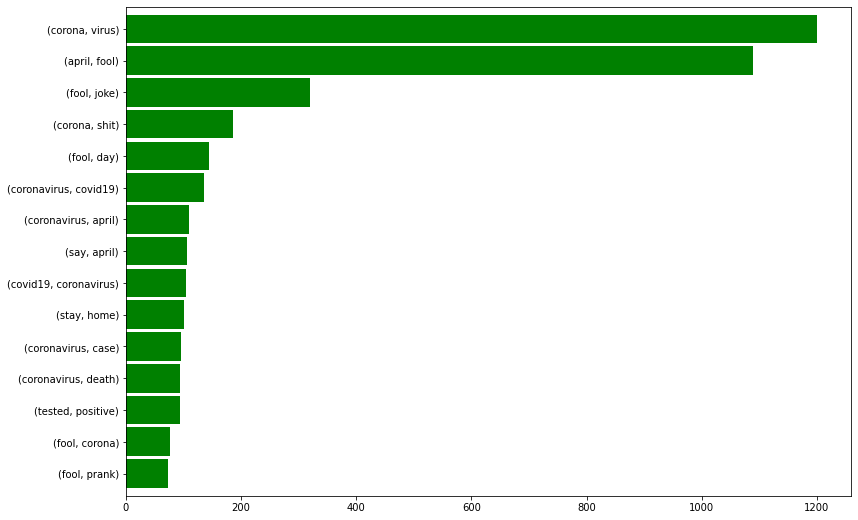

In [ ]:
bigrams_series = (pd.Series(nltk.ngrams(words, 2)).value_counts())[:15]
trigrams_series = (pd.Series(nltk.ngrams(words, 3)).value_counts())[:15]

bigrams_series.sort_values().plot.barh(color = 'green', width = 0.9, figsize = (13, 9))

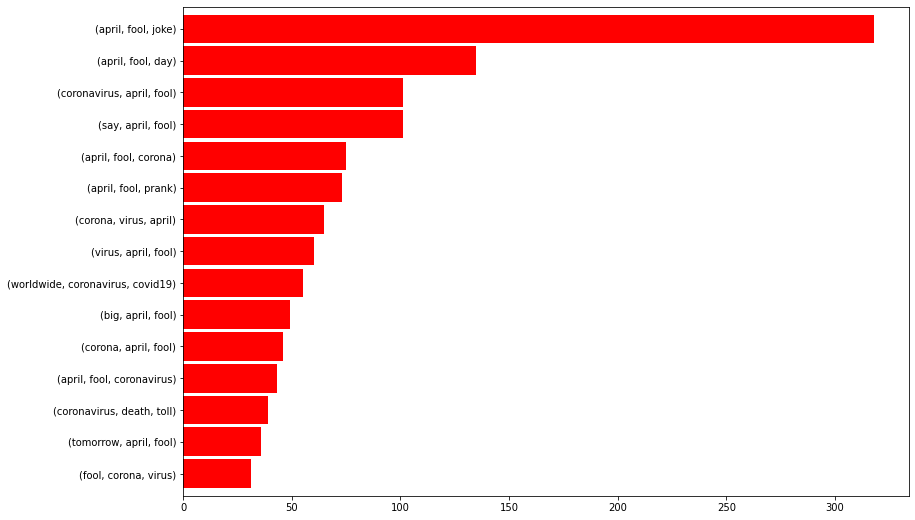

In [ ]:
trigrams_series.sort_values().plot.barh(color = 'red', width = 0.9, figsize = (13, 9))

## **Preprocessing**

In [ ]:
contractions = { 
"ain't": "am not", "aren't": "are not", "can't": "cannot", "can't've": "cannot have", "'cause": "because", "could've": "could have", "couldn't": "could not",
"couldn't've": "could not have", "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hadn't've": "had not have",
"hasn't": "has not", "haven't": "have not", "he'd": "he had", "he'd've": "he would have", "he'll": "he will", "he'll've": "he will have", "he's": "he is",
"how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "i'd": "i would", "i'd've": "i would have",
"i'll": "i will", "i'll've": "i will have", "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
"it'd've": "it would have", "it'll": "it will", "it'll've": "it will have", "it's": "it is", "let's": "let us",
"ma'am": "madam", "mayn't": "may not", "might've": "might have", "mightn't": "might not", "mightn't've": "might not have", "must've": "must have", "mustn't": "must not",
"mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have", "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have",
"shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she shall / she will",
"she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have",
"so've": "so have", "so's": "so is", "that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
"there'd've": "there would have", "there's": "there is", "they'd": "they would", "they'd've": "they would have", "they'll": "they will",
"they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would",
"we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will",
"what'll've": "what will have", "what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is",
"when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have",
"who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
"would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would", "y'all'd've": "you all would have",
"y'all're": "you all are", "y'all've": "you all have", "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
"you're": "you are", "you've": "you have"
}

In [ ]:
contractionsWithAnotherInvertedComma = { 
"ain’t": "am not", "aren’t": "are not", "can’t": "cannot", "can’t’ve": "cannot have", "’cause": "because", "could’ve": "could have", "couldn’t": "could not",
"couldn’t’ve": "could not have", "didn’t": "did not", "doesn’t": "does not", "don’t": "do not", "hadn’t": "had not", "hadn’t’ve": "had not have",
"hasn’t": "has not", "haven’t": "have not", "he’d": "he had", "he’d’ve": "he would have", "he’ll": "he will", "he’ll’ve": "he will have", "he’s": "he is",
"how’d": "how did", "how’d’y": "how do you", "how’ll": "how will", "how’s": "how is", "i’d": "i would", "i’d’ve": "i would have",
"i’ll": "i will", "i’ll’ve": "i will have", "i’m": "i am", "i’ve": "i have", "isn’t": "is not", "it’d": "it would",
"it’d’ve": "it would have", "it’ll": "it will", "it’ll’ve": "it will have", "it’s": "it is", "let’s": "let us",
"ma’am": "madam", "mayn’t": "may not", "might’ve": "might have", "mightn’t": "might not", "mightn’t’ve": "might not have", "must’ve": "must have", "mustn’t": "must not",
"mustn’t’ve": "must not have", "needn’t": "need not", "needn’t’ve": "need not have", "o’clock": "of the clock", "oughtn’t": "ought not", "oughtn’t’ve": "ought not have",
"shan’t": "shall not", "shan’t’ve": "shall not have", "she’d": "she would", "she’d’ve": "she would have", "she’ll": "she will",
"she’ll’ve": "she will have", "she’s": "she is", "should’ve": "should have", "shouldn’t": "should not", "shouldn’t’ve": "should not have",
"so’ve": "so have", "so’s": "so is", "that’d": "that would", "that’d’ve": "that would have", "that’s": "that is", "there’d": "there would",
"there’d’ve": "there would have", "there’s": "there is", "they’d": "they would", "they’d’ve": "they would have", "they’ll": "they will",
"they’ll’ve": "they will have", "they’re": "they are", "they’ve": "they have", "to’ve": "to have", "wasn’t": "was not", "we’d": "we would",
"we’d’ve": "we would have", "we’ll": "we will", "we’ll’ve": "we will have", "we’re": "we are", "we’ve": "we have", "weren’t": "were not", "what’ll": "what will",
"what'll've": "what will have", "what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is",
"when’ve": "when have", "where’d": "where did", "where’s": "where is", "where’ve": "where have", "who’ll": "who will", "who’ll’ve": "who will have",
"who’s": "who is", "who’ve": "who have", "why’s": "why is", "why’ve": "why have", "will’ve": "will have", "won’t": "will not", "won’t’ve": "will not have",
"would’ve": "would have", "wouldn’t": "would not", "wouldn’t’ve": "would not have", "y’all": "you all", "y’all’d": "you all would", "y’all’d’ve": "you all would have",
"y’all’re": "you all are", "y’all’ve": "you all have", "you’d": "you would", "you’d’ve": "you would have", "you’ll": "you will", "you’ll’ve": "you will have",
"you’re": "you are", "you’ve": "you have"
}

In [ ]:
from COVID19_sentinentanalysissocialmedia.preprocessing.preprocess import preprocess
pp_class = preprocess(senwave, contractions, contractionsWithAnotherInvertedComma)
senwave['Tweet'] = senwave['Tweet'].apply(lambda x : pp_class.preprocess_tweet(x))

In [ ]:
senwave['Tweet'] = senwave['Tweet'].str.lower()
senwave.head(10)

,ID,Tweet,Optimistic,Thankful,Empathetic,Pessimistic,Anxious,Sad,Annoyed,Denial,Official report,Surprise,Joking
0,1.245140e+18,a glass of wine keeps the corona away drake ...,1,0,0,0,0,0,0,0,0,0,1
1,1.245140e+18,can anyone tell me if you took the flu shot la...,0,0,0,0,1,0,0,0,0,1,0
2,1.245140e+18,by the way producers send me beats i am workin...,1,0,0,0,0,0,0,0,0,0,1
3,1.245140e+18,when someone you know apart of your family d...,0,0,0,0,0,1,0,0,0,0,0
4,1.245140e+18,dear soccer \ni really miss you please come b...,0,0,0,0,0,1,1,0,0,0,0
5,1.245140e+18,new home remedy to treat coronavirus tested b...,1,0,0,0,0,0,0,1,0,0,1
6,1.245140e+18,when xavier wulf does an attack on titan tape ...,0,0,0,0,0,0,0,0,0,0,1
7,1.245140e+18,mouthwash is hand san for your mouth and i do ...,0,0,0,0,0,1,0,0,0,1,1
8,1.245140e+18,yes all of them i̇n france 1 000 christian...,0,0,0,0,0,0,1,0,1,1,0
9,1.245140e+18,update i destroyed the tire pensive face hones...,0,0,0,1,0,1,0,0,0,0,0


In [ ]:
def check_coverage(vocab, embeddings_index):
    a = {}
    oov = {}
    k = 0
    i = 0
    for word in tqdm(vocab):
        try:
            a[word] = embeddings_index[word]
            k += vocab[word]
        except:
            oov[word] = vocab[word]
            i += vocab[word]
            pass
        
    print('Found embeddings for {:.2%} of vocab'.format(len(a) / len(vocab)))
    print('Found embeddings for  {:.2%} of all text'.format(k / (k + i)))
    sorted_x = sorted(oov.items(), key = operator.itemgetter(1))[::-1]

    return sorted_x

def build_vocab(sentences, verbose = True):
    vocab = {}
    for sentence in tqdm(sentences, disable = (not verbose)):
        for word in sentence:
            try:
                vocab[word] += 1
            except:
                vocab[word] = 1
    return vocab

def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')


def load_embeddings(path):
    with open(path, encoding = "utf-8") as f:
        return dict(get_coefs(*line.strip().split(' ')) for line in f)


def build_matrix(word_index, path):
    embedding_index = load_embeddings(path)
    embedding_matrix = np.zeros((len(word_index) + 1, 300))
    for word, i in word_index.items():
        try:
            embedding_matrix[i] = embedding_index[word]
        except KeyError:
            pass
    return embedding_matrix

In [ ]:
GLOVE_EMBEDDING_FILE = '/content/drive/MyDrive/Covid 19 India/glove.840B.300d.txt'
glove_embeddings = load_embeddings(GLOVE_EMBEDDING_FILE)
print(f'loaded {len(glove_embeddings)} word vectors ')

loaded 2196007 word vectors 


In [ ]:
vocab = build_vocab(list(senwave['Tweet'].apply(lambda x : x.split())))
oov = check_coverage(vocab, glove_embeddings)
oov[:10]


Found embeddings for 82.88% of vocab
Found embeddings for  98.31% of all text


[('coronavirusngr', 6),
 ('234radio', 6),
 ('‘s', 6),
 ('coronavirusiot', 6),
 ('2007218893', 5),
 ('b’s', 5),
 ('orkfromhome', 5),
 ('mom’s', 5),
 ('“my', 5),
 ('uhan', 5)]

In [ ]:
from COVID19_sentinentanalysissocialmedia.preprocessing import wordReplace
senwave['Tweet'] = senwave['Tweet'].apply(lambda x : wordReplace.bruteGen(x))

## **Building the model followed by training & testing**

In [ ]:
from sklearn.model_selection import train_test_split
sen_train, sen_test = train_test_split(senwave, train_size = 0.9, random_state = 1024)

sen_train.to_csv("train.csv", index = False)
sen_test.to_csv("test.csv", index = False)

In [ ]:
sen_train.head(1)

,ID,Tweet,Optimistic,Thankful,Empathetic,Pessimistic,Anxious,Sad,Annoyed,Denial,Official report,Surprise,Joking
560,1.245140e+18,minister for agriculture mahendra reddy to hol...,0,0,0,0,0,0,0,0,1,0,0


In [ ]:
import spacy
spacy_en = spacy.load('en')

def tokenizer(tweet):
    tweet = re.sub(r'[\n]', ' ', tweet)
    return [tok.text for tok in spacy_en.tokenizer(tweet)]

TWEET = data.Field(sequential = True, lower = True, tokenize = tokenizer)
LABEL = data.Field(sequential = False, use_vocab = False)

dataFields = [("ID", None), ("Tweet", TWEET), ("Optimistic", LABEL), ("Thankful", LABEL),
              ("Empathetic", LABEL), ("Pessimistic", LABEL), ("Anxious", LABEL), ("Sad", LABEL),
              ("Annoyed", LABEL), ("Denial", LABEL), ("Official report", LABEL),
              ("Surprise", LABEL), ("Joking", LABEL)]

train_dataset, test_dataset = data.TabularDataset.splits(
    path = '/content/', train = 'train.csv', test = 'test.csv', format = 'csv', fields = dataFields, skip_header = True
    )

In [ ]:
print("Number of training samples : {}\n Number of testing samples : {}".format(len(train_dataset), len(test_dataset)))

Number of training samples : 9000
 Number of testing samples : 1000


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
TWEET.build_vocab(train_dataset, vectors = 'glove.840B.300d')

**Hyperparameters to be considered**
*  Learning Rate
*  Hidden Dimension of LSTM
*  Dropout Probability
*  Threshold



In [ ]:
vocab = TWEET.vocab
BATCH_SIZE = 32
n_label = 11
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iter, test_iter = data.BucketIterator.splits(datasets = (train_dataset, test_dataset),
                                                   batch_size = BATCH_SIZE,
                                                   sort_key = lambda x : len(x.Tweet),
                                                   sort_within_batch = False,
                                                   repeat = False,
                                                   device = device)

In [ ]:
np.random.seed(1024)
for i in range(TWEET.vocab.vectors.shape[0]):
    vec = TWEET.vocab.vectors[i]
    if torch.sum(vec).item() == 0:
        a = np.random.uniform(-0.25, 0.25, 300)
        TWEET.vocab.vectors[i] = torch.from_numpy(a)

In [ ]:
batch = next(train_iter.__iter__()); batch


[torchtext.data.batch.Batch of size 32]
	[.Tweet]:[torch.cuda.LongTensor of size 30x32 (GPU 0)]
	[.Optimistic]:[torch.cuda.LongTensor of size 32 (GPU 0)]
	[.Thankful]:[torch.cuda.LongTensor of size 32 (GPU 0)]
	[.Empathetic]:[torch.cuda.LongTensor of size 32 (GPU 0)]
	[.Pessimistic]:[torch.cuda.LongTensor of size 32 (GPU 0)]
	[.Anxious]:[torch.cuda.LongTensor of size 32 (GPU 0)]
	[.Sad]:[torch.cuda.LongTensor of size 32 (GPU 0)]
	[.Annoyed]:[torch.cuda.LongTensor of size 32 (GPU 0)]
	[.Denial]:[torch.cuda.LongTensor of size 32 (GPU 0)]
	[.Official report]:[torch.cuda.LongTensor of size 32 (GPU 0)]
	[.Surprise]:[torch.cuda.LongTensor of size 32 (GPU 0)]
	[.Joking]:[torch.cuda.LongTensor of size 32 (GPU 0)]

In [ ]:
#idea taken from http://mlexplained.com/2018/02/08/a-comprehensive-tutorial-to-torchtext/
class BatchWrapper():
    def __init__(self, dl, x_var, y_vars):
        self.dl = dl
        self.x_var = x_var
        self.y_vars = y_vars

    def __iter__(self):
        for batch in self.dl:
            x = getattr(batch, self.x_var)
            if self.y_vars is not None:
                y = torch.cat([getattr(batch, feat).unsqueeze(1) for feat in self.y_vars], dim = 1).float()
            else:
                y = torch.zeros((1))
            yield(x, y)
    
    def __len__(self):
        return len(self.dl)

In [ ]:
train_dl = BatchWrapper(train_iter, "Tweet", ['Optimistic', 'Thankful', 'Empathetic', 'Pessimistic', 
                                              'Anxious', 'Sad', 'Annoyed', 'Denial', 'Official report', 'Surprise', 'Joking'])
test_dl = BatchWrapper(test_iter, "Tweet", ['Optimistic', 'Thankful', 'Empathetic', 'Pessimistic', 
                                            'Anxious', 'Sad', 'Annoyed', 'Denial', 'Official report', 'Surprise', 'Joking'])

In [ ]:
class CustomLSTM(nn.Module):
    def __init__(self, embedding_dim, vocab, hidden_dim, output_dim, drop_prob, bidirectional = False, use_glove = True):
        super().__init__()
        self.embeddings = nn.Embedding(len(vocab), embedding_dim)
        if use_glove:
            self.embeddings.weight.data.copy_(vocab.vectors)
            self.embeddings.weight.requires_grad = False
        self.drop_prob = drop_prob

        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional = bidirectional, batch_first = True, num_layers = 2)
        if bidirectional is True:
            self.lin = nn.Linear(2*hidden_dim, 64)
        else:
            self.lin = nn.Linear(hidden_dim, 64)
        self.fc = nn.Linear(64, output_dim)
        self.dropout = nn.Dropout(p = drop_prob)
    
    def forward(self, sentence):
        #sentence = [max_len, batch_size]

        embed = self.embeddings(torch.transpose(sentence, 0, 1))
        #embed = [batch_size, max_len, embedding_dim]
        
        if self.drop_prob:
            embed = self.dropout(embed)
        
        lstm_out, (hidden, cell) = self.lstm(embed)
        #lstm_out = [batch_size, max_len, 2*hidden_dim if bidirectional else hidden_dim]
        #hidden = [num_layers, batch_size, hidden_dim]
        #cell = [num_layers, batch_size, hidden_dim]
        
        out = lstm_out[:,-1,:].squeeze()
        #out = [batch_size, 2*hidden_dim if bidirectional else hidden_dim]
        
        out = self.lin(out)
        #out = [batch_size, 64]

        outputs = self.fc(out)
        #outputs = [batch_size, output_dim]
        
        return outputs

In [ ]:
def evaluation_metrics(actual_labels, pred_labels, threshold):
    int_pred_labels = pred_labels
    for i in range(len(pred_labels)):
        for j in range(11):
            if int_pred_labels[i][j] >= threshold: int_pred_labels[i][j] = 1
            else:
                int_pred_labels[i][j] = 0
    
    ham_loss = hamming_loss(actual_labels, int_pred_labels)
    jacc_score = jaccard_score(actual_labels, int_pred_labels, average = 'samples')
    lrap = label_ranking_average_precision_score(actual_labels, pred_labels)
    f1_macro = f1_score(actual_labels, int_pred_labels, average = 'macro')
    f1_micro = f1_score(actual_labels, int_pred_labels, average = 'micro')

    return ham_loss, jacc_score, lrap, f1_macro, f1_micro

In [ ]:
def train(model, loss_fn, optimizer, n_epochs, train_dl, threshold):

    train_losses = []  
    hamming_losses = []
    jaccard_scores = []
    lraps = []  
    iter = 1

    for epoch in range(1, n_epochs+1):
        running_loss = 0.0
        pred_labels = []
        actual_labels = []
        model.train()
        for x, y in train_dl:
            #print(x.shape, y.shape)
            optimizer.zero_grad()

            preds = model(x)

            m = nn.Sigmoid()
            sig_preds = m(preds)
            
            for tens in sig_preds:
                pred_labels.append(tens.cpu().detach().numpy())
            for tens in y:
                actual_labels.append(tens.cpu().detach().numpy())

            loss = loss_fn(preds, y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * x.shape[0]

        ham_loss, jacc_score, lrap, f1_macro, f1_micro = evaluation_metrics(actual_labels, pred_labels, threshold)

        epoch_loss = running_loss / len(train_dataset)
        train_losses.append(epoch_loss)
        hamming_losses.append(ham_loss)
        lraps.append(lrap)
        jaccard_scores.append(jacc_score)
        '''
        if iter % 5 == 0:
            print("Epoch: ", epoch)
            print("Binary Cross Entropy With Logits Loss: {:.4f}".format(epoch_loss))
            print("Hamming Loss : {:.4f}".format(ham_loss))
            print("Jaccard Score: {:.4f}".format(jacc_score))
            print("Label Ranking Average Precision Score: {:.4f}".format(lrap))
            print("F1 Macro Score: {:.4f}".format(f1_macro))
            print("F1 Micro Score: {:.4f}".format(f1_micro))
            print("\n")
        iter += 1
        '''
    return train_losses, hamming_losses, jaccard_scores, lraps, f1_macro, f1_micro

In [ ]:
def test(model, loss_fn, test_dl, threshold):
    running_loss = 0.0
    pred_labels = []
    actual_labels = []
    model.eval()
    for x, y in test_dl:
        #print(x.shape, y.shape)

        preds = model(x)

        m = nn.Sigmoid()
        sig_preds = m(preds)
        
        for tens in sig_preds:
            pred_labels.append(tens.cpu().detach().numpy())
        for tens in y:
            actual_labels.append(tens.cpu().detach().numpy())

        loss = loss_fn(preds, y)

        running_loss += loss.item() * x.shape[0]

    ham_loss, jacc_score, lrap, f1_macro, f1_micro = evaluation_metrics(actual_labels, pred_labels, threshold)

    test_loss = running_loss / len(test_dataset)
    return test_loss, ham_loss, jacc_score, lrap, f1_macro, f1_micro

# **Experimentation with various combinations of the hyperparameters**

## Till 22-12-2020

In [ ]:
learning_rates = [1e-3]
hidden_dims = [128, 256]
thresholds = [0.4, 0.45, 0.5]
dropouts = [True, False]

all_models = []
iter = 1
#number of iterations = 3*2*2 = 12 = number of models

for learning_rate in learning_rates:
    for hidden_dim in hidden_dims:
        for threshold in thresholds:
            for dropout in dropouts:
                model = CustomLSTM(embedding_dim = vocab.vectors.shape[1], vocab = vocab, hidden_dim = hidden_dim, output_dim = 11, drop_prob = dropout)
                model = model.to(device)

                optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
                loss_fn = nn.BCEWithLogitsLoss()

                train_loss, hamm_loss, jacc_score, lrap, f1_macro, f1_micro = train(model, loss_fn, optimizer, 50, train_dl, threshold)
                all_models.append(model)
                print("Iteration : {}".format(iter))
                print("Learning Rate : {}, Hidden Dimension : {}, Threshold : {}, Dropout = {}".format(learning_rate, hidden_dim, threshold, dropout))
                print("Binary Cross Entropy With Logits Loss: {:.4f}".format(min(train_loss)))
                print("Hamming Loss : {:.4f}".format(min(hamm_loss)))
                print("Jaccard Score: {:.4f}".format(max(jacc_score)))
                print("Label Ranking Average Precision Score: {:.4f}".format(max(lrap)))
                print("F1 Macro Score: {:.4f}".format(f1_macro))
                print("F1 Micro Score: {:.4f}".format(f1_micro))
                print("\n")

                test_loss, test_hamm_loss, test_jacc_score, test_lrap, test_f1_macro, test_f1_micro = test(model, loss_fn, test_dl, threshold)
                print("TestBinary Cross Entropy With Logits Loss: {:.4f}".format(test_loss))
                print("Test Hamming Loss : {:.4f}".format(test_hamm_loss))
                print("Test Jaccard Score: {:.4f}".format(test_jacc_score))
                print("Test Label Ranking Average Precision Score: {:.4f}".format(test_lrap))
                print("Test F1 Macro Score: {:.4f}".format(test_f1_macro))
                print("Test F1 Micro Score: {:.4f}".format(test_f1_micro))
                print("\n")
                print("----------------------------------------------------------------")
                iter += 1

Iteration : 1
Learning Rate : 0.001, Hidden Dimension : 128, Threshold : 0.4, Dropout = True
Binary Cross Entropy With Logits Loss: 0.2243
Hamming Loss : 0.0980
Jaccard Score: 0.6457
Label Ranking Average Precision Score: 0.6859
F1 Macro Score: 0.6639
F1 Micro Score: 0.7220


TestBinary Cross Entropy With Logits Loss: 0.2692
Test Hamming Loss : 0.1750
Test Jaccard Score: 0.4025
Test Label Ranking Average Precision Score: 0.4796
Test F1 Macro Score: 0.4352
Test F1 Micro Score: 0.4882


----------------------------------------------------------------
Iteration : 2
Learning Rate : 0.001, Hidden Dimension : 128, Threshold : 0.4, Dropout = False
Binary Cross Entropy With Logits Loss: 0.0248
Hamming Loss : 0.0084
Jaccard Score: 0.9688
Label Ranking Average Precision Score: 0.9721
F1 Macro Score: 0.9698
F1 Micro Score: 0.9770


TestBinary Cross Entropy With Logits Loss: 0.7358
Test Hamming Loss : 0.1865
Test Jaccard Score: 0.3835
Test Label Ranking Average Precision Score: 0.4591
Test F1 Macr

## 23-12-2020
*  taking inference from the previous days, having a dropout in the LSTM layer has always lowered the overfitting. Hence we will be using dropout layers in all models today.
*  We shall experiment with the values of the dropout probability today

In [ ]:
learning_rates = [1e-3]
hidden_dims = [128, 256]
thresholds = [0.4, 0.45, 0.5]
drop_probs = [0.4, 0.5, 0.6, 0.7]

all_models = []
iter = 1
#number of iterations = 4*3*2 = 24 = number of models

for learning_rate in learning_rates:
    for hidden_dim in hidden_dims:
        for threshold in thresholds:
            for drop_prob in drop_probs:
                model = CustomLSTM(embedding_dim = vocab.vectors.shape[1], vocab = vocab, hidden_dim = hidden_dim, output_dim = 11, drop_prob = drop_prob)
                model = model.to(device)

                optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
                loss_fn = nn.BCEWithLogitsLoss()

                train_loss, hamm_loss, jacc_score, lrap, f1_macro, f1_micro = train(model, loss_fn, optimizer, 50, train_dl, threshold)
                all_models.append(model)
                print("Iteration : {}".format(iter))
                print("Learning Rate : {}, Hidden Dimension : {}, Threshold : {}, Dropout Probability = {}".format(learning_rate, hidden_dim, threshold, drop_prob))
                print("Binary Cross Entropy With Logits Loss: {:.4f}".format(min(train_loss)))
                print("Hamming Loss : {:.4f}".format(min(hamm_loss)))
                print("Jaccard Score: {:.4f}".format(max(jacc_score)))
                print("Label Ranking Average Precision Score: {:.4f}".format(max(lrap)))
                print("F1 Macro Score: {:.4f}".format(f1_macro))
                print("F1 Micro Score: {:.4f}".format(f1_micro))
                print("\n")

                test_loss, test_hamm_loss, test_jacc_score, test_lrap, test_f1_macro, test_f1_micro = test(model, loss_fn, test_dl, threshold)
                print("TestBinary Cross Entropy With Logits Loss: {:.4f}".format(test_loss))
                print("Test Hamming Loss : {:.4f}".format(test_hamm_loss))
                print("Test Jaccard Score: {:.4f}".format(test_jacc_score))
                print("Test Label Ranking Average Precision Score: {:.4f}".format(test_lrap))
                print("Test F1 Macro Score: {:.4f}".format(test_f1_macro))
                print("Test F1 Micro Score: {:.4f}".format(test_f1_micro))
                print("\n")
                print("----------------------------------------------------------------")
                iter += 1

Iteration : 1
Learning Rate : 0.001, Hidden Dimension : 128, Threshold : 0.4, Dropout Probability = 0.4
Binary Cross Entropy With Logits Loss: 0.1793
Hamming Loss : 0.0765
Jaccard Score: 0.7205
Label Ranking Average Precision Score: 0.7503
F1 Macro Score: 0.7465
F1 Micro Score: 0.7877


TestBinary Cross Entropy With Logits Loss: 0.3169
Test Hamming Loss : 0.1803
Test Jaccard Score: 0.4085
Test Label Ranking Average Precision Score: 0.4805
Test F1 Macro Score: 0.4341
Test F1 Micro Score: 0.4955


----------------------------------------------------------------
Iteration : 2
Learning Rate : 0.001, Hidden Dimension : 128, Threshold : 0.4, Dropout Probability = 0.5
Binary Cross Entropy With Logits Loss: 0.2085
Hamming Loss : 0.0896
Jaccard Score: 0.6749
Label Ranking Average Precision Score: 0.7113
F1 Macro Score: 0.6880
F1 Micro Score: 0.7472


TestBinary Cross Entropy With Logits Loss: 0.2869
Test Hamming Loss : 0.1801
Test Jaccard Score: 0.4089
Test Label Ranking Average Precision Score

# Some inferences
*  Best Test BCE with logits loss at Iteration 12<br>
*  Best Test Hamming Loss at Iteration 12<br>
*  Best Test Jaccard Score at Iteration 3 & 16<br>
*  Best Test LRAP Score at Iteration 11<br>
*  Best Test F1 Macro Score at Iteration 16<br>
*  Best Test F1 Micro Score at Iteration 3<br>
<br> <br>
*  This indicates that we need only consider hyperparams corresponding to iterations 3, 11, 12 and 16



 **Hyperparameters to be considered for the final steps**:

*   Learning Rate: 0.001
*   Hidden Dimension: 3, 11, 12 = 128 & 16 = 256
*   Threshold: 3 & 16 = 0.4, 11 & 12 = 0.5
*   Dropout Probability: 3 & 11 = 0.6, 12 & 16 = 0.7

Since we see that either the best hyperparameters correspond to dropout probability = 0.6 or 0.7, we use dropout probability = 0.65 which is verified below as performing nearly the same or better

## Final evaluation using narrowed down hyperparameters
26-12-2020

In [ ]:
%%time
learning_rate = 1e-3
hidden_dim = 128
threshold = 0.5
drop_prob = 0.65

all_bce_losses = []
all_hamm_losses = []
all_jacc_scores = []
all_lraps = []
all_f1_macro = []
all_f1_micro = []
all_models = []

for exp in range(1, 11):

    print("Experiment {}".format(exp), '\n\n')

    model = CustomLSTM(embedding_dim = vocab.vectors.shape[1], vocab = vocab, hidden_dim = hidden_dim, output_dim = 11, drop_prob = drop_prob)
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    loss_fn = nn.BCEWithLogitsLoss()

    train_loss, hamm_loss, jacc_score, lrap, f1_macro, f1_micro = train(model, loss_fn, optimizer, 50, train_dl, threshold)
    torch.save(model, 'model{}.pth'.format(exp))
    '''
    print("Learning Rate : {}, Hidden Dimension : {}, Threshold : {}, Dropout Probability = {}".format(learning_rate, hidden_dim, threshold, drop_prob))
    print("Binary Cross Entropy With Logits Loss: {:.4f}".format(min(train_loss)))
    print("Hamming Loss : {:.4f}".format(min(hamm_loss)))
    print("Jaccard Score: {:.4f}".format(max(jacc_score)))
    print("Label Ranking Average Precision Score: {:.4f}".format(max(lrap)))
    print("F1 Macro Score: {:.4f}".format(f1_macro))
    print("F1 Micro Score: {:.4f}".format(f1_micro))
    print("\n")
    '''

    test_loss, test_hamm_loss, test_jacc_score, test_lrap, test_f1_macro, test_f1_micro = test(model, loss_fn, test_dl, threshold)
    all_bce_losses.append(test_loss)
    all_hamm_losses.append(test_hamm_loss)
    all_jacc_scores.append(test_jacc_score)
    all_lraps.append(test_lrap)
    all_f1_macro.append(test_f1_macro)
    all_f1_micro.append(test_f1_micro)


    print("TestBinary Cross Entropy With Logits Loss: {:.4f}".format(test_loss))
    print("Test Hamming Loss : {:.4f}".format(test_hamm_loss))
    print("Test Jaccard Score: {:.4f}".format(test_jacc_score))
    print("Test Label Ranking Average Precision Score: {:.4f}".format(test_lrap))
    print("Test F1 Macro Score: {:.4f}".format(test_f1_macro))
    print("Test F1 Micro Score: {:.4f}".format(test_f1_micro))
    print("\n")

Experiment 1 


TestBinary Cross Entropy With Logits Loss: 0.2604
Test Hamming Loss : 0.1605
Test Jaccard Score: 0.4012
Test Label Ranking Average Precision Score: 0.4961
Test F1 Macro Score: 0.4334
Test F1 Micro Score: 0.4804


Experiment 2 


TestBinary Cross Entropy With Logits Loss: 0.2507
Test Hamming Loss : 0.1594
Test Jaccard Score: 0.4120
Test Label Ranking Average Precision Score: 0.5042
Test F1 Macro Score: 0.4276
Test F1 Micro Score: 0.4888


Experiment 3 


TestBinary Cross Entropy With Logits Loss: 0.2519
Test Hamming Loss : 0.1545
Test Jaccard Score: 0.4255
Test Label Ranking Average Precision Score: 0.5207
Test F1 Macro Score: 0.4378
Test F1 Micro Score: 0.4939


Experiment 4 


TestBinary Cross Entropy With Logits Loss: 0.2712
Test Hamming Loss : 0.1623
Test Jaccard Score: 0.4084
Test Label Ranking Average Precision Score: 0.4984
Test F1 Macro Score: 0.4265
Test F1 Micro Score: 0.4878


Experiment 5 


TestBinary Cross Entropy With Logits Loss: 0.2541
Test Hamming Loss 

In [ ]:
print("Average Binary Cross Entropy With Logits Loss: {:.4f}".format(sum(all_bce_losses)/10))
print("Average Hamming Loss : {:.4f}".format(sum(all_hamm_losses)/10))
print("Average Jaccard Score: {:.4f}".format(sum(all_jacc_scores)/10))
print("Average Label Ranking Average Precision Score: {:.4f}".format(sum(all_lraps)/10))
print("Average F1 Macro Score: {:.4f}".format(sum(all_f1_macro)/10))
print("Average F1 Micro Score: {:.4f}".format(sum(all_f1_micro)/10))

Average Binary Cross Entropy With Logits Loss: 0.2552
Average Hamming Loss : 0.1569
Average Jaccard Score: 0.4184
Average Label Ranking Average Precision Score: 0.5111
Average F1 Macro Score: 0.4308
Average F1 Micro Score: 0.4934


**Model 7 performed the best, so I downloaded the weights**

## Using a different value of dropout probability

In [ ]:
%%time
learning_rate = 1e-3
hidden_dim = 128
threshold = 0.5
drop_prob = 0.6

all_bce_losses = []
all_hamm_losses = []
all_jacc_scores = []
all_lraps = []
all_f1_macro = []
all_f1_micro = []
all_models = []

for exp in range(1, 11):

    print("Experiment {}".format(exp), '\n\n')

    model = CustomLSTM(embedding_dim = vocab.vectors.shape[1], vocab = vocab, hidden_dim = hidden_dim, output_dim = 11, drop_prob = drop_prob)
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    loss_fn = nn.BCEWithLogitsLoss()

    train_loss, hamm_loss, jacc_score, lrap, f1_macro, f1_micro = train(model, loss_fn, optimizer, 50, train_dl, threshold)
    torch.save(model, 'model{}.pth'.format(exp))
    '''
    print("Learning Rate : {}, Hidden Dimension : {}, Threshold : {}, Dropout Probability = {}".format(learning_rate, hidden_dim, threshold, drop_prob))
    print("Binary Cross Entropy With Logits Loss: {:.4f}".format(min(train_loss)))
    print("Hamming Loss : {:.4f}".format(min(hamm_loss)))
    print("Jaccard Score: {:.4f}".format(max(jacc_score)))
    print("Label Ranking Average Precision Score: {:.4f}".format(max(lrap)))
    print("F1 Macro Score: {:.4f}".format(f1_macro))
    print("F1 Micro Score: {:.4f}".format(f1_micro))
    print("\n")
    '''

    test_loss, test_hamm_loss, test_jacc_score, test_lrap, test_f1_macro, test_f1_micro = test(model, loss_fn, test_dl, threshold)
    all_bce_losses.append(test_loss)
    all_hamm_losses.append(test_hamm_loss)
    all_jacc_scores.append(test_jacc_score)
    all_lraps.append(test_lrap)
    all_f1_macro.append(test_f1_macro)
    all_f1_micro.append(test_f1_micro)


    print("TestBinary Cross Entropy With Logits Loss: {:.4f}".format(test_loss))
    print("Test Hamming Loss : {:.4f}".format(test_hamm_loss))
    print("Test Jaccard Score: {:.4f}".format(test_jacc_score))
    print("Test Label Ranking Average Precision Score: {:.4f}".format(test_lrap))
    print("Test F1 Macro Score: {:.4f}".format(test_f1_macro))
    print("Test F1 Micro Score: {:.4f}".format(test_f1_micro))
    print("\n")

Experiment 1 


TestBinary Cross Entropy With Logits Loss: 0.2631
Test Hamming Loss : 0.1569
Test Jaccard Score: 0.4346
Test Label Ranking Average Precision Score: 0.5218
Test F1 Macro Score: 0.4377
Test F1 Micro Score: 0.5069


Experiment 2 


TestBinary Cross Entropy With Logits Loss: 0.2536
Test Hamming Loss : 0.1557
Test Jaccard Score: 0.4434
Test Label Ranking Average Precision Score: 0.5284
Test F1 Macro Score: 0.4371
Test F1 Micro Score: 0.5138


Experiment 3 


TestBinary Cross Entropy With Logits Loss: 0.2623
Test Hamming Loss : 0.1540
Test Jaccard Score: 0.4318
Test Label Ranking Average Precision Score: 0.5221
Test F1 Macro Score: 0.4358
Test F1 Micro Score: 0.5067


Experiment 4 


TestBinary Cross Entropy With Logits Loss: 0.2690
Test Hamming Loss : 0.1653
Test Jaccard Score: 0.4191
Test Label Ranking Average Precision Score: 0.5040
Test F1 Macro Score: 0.4517
Test F1 Micro Score: 0.4947


Experiment 5 


TestBinary Cross Entropy With Logits Loss: 0.2645
Test Hamming Loss 

In [ ]:
print("Average Binary Cross Entropy With Logits Loss: {:.4f}".format(sum(all_bce_losses)/10))
print("Average Hamming Loss : {:.4f}".format(sum(all_hamm_losses)/10))
print("Average Jaccard Score: {:.4f}".format(sum(all_jacc_scores)/10))
print("Average Label Ranking Average Precision Score: {:.4f}".format(sum(all_lraps)/10))
print("Average F1 Macro Score: {:.4f}".format(sum(all_f1_macro)/10))
print("Average F1 Micro Score: {:.4f}".format(sum(all_f1_micro)/10))

Average Binary Cross Entropy With Logits Loss: 0.2660
Average Hamming Loss : 0.1577
Average Jaccard Score: 0.4311
Average Label Ranking Average Precision Score: 0.5175
Average F1 Macro Score: 0.4422
Average F1 Micro Score: 0.5060


## Comparison between having GloVe Vectors and not having GloVe Vectors 
28-12-2020

In [ ]:
%%time
learning_rate = 1e-3
hidden_dim = 128
threshold = 0.5
drop_prob = 0.65

all_glove_losses = []
all_glove_ham = []
all_glove_jacc = []
all_glove_lrap = []
all_glove_f1mac = []
all_glove_f1mic = []

all_nonglove_losses = []
all_nonglove_ham = []
all_nonglove_jacc = []
all_nonglove_lrap = []
all_nonglove_f1mac = []
all_nonglove_f1mic = []

glove = [True, False]
for exp in range(1, 11):
    for g in glove:
        model = CustomLSTM(embedding_dim = vocab.vectors.shape[1], vocab = vocab, hidden_dim = hidden_dim, output_dim = 11, drop_prob = drop_prob, use_glove = g)
        model = model.to(device)

        optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
        loss_fn = nn.BCEWithLogitsLoss()

        train_loss, hamm_loss, jacc_score, lrap, f1_macro, f1_micro = train(model, loss_fn, optimizer, 50, train_dl, threshold)
        test_loss, test_hamm_loss, test_jacc_score, test_lrap, test_f1_macro, test_f1_micro = test(model, loss_fn, test_dl, threshold)
        print("Test Binary Cross Entropy With Logits Loss: {:.4f}".format(test_loss))
        print("Test Hamming Loss : {:.4f}".format(test_hamm_loss))
        print("Test Jaccard Score: {:.4f}".format(test_jacc_score))
        print("Test Label Ranking Average Precision Score: {:.4f}".format(test_lrap))
        print("Test F1 Macro Score: {:.4f}".format(test_f1_macro))
        print("Test F1 Micro Score: {:.4f}".format(test_f1_micro))
        print("\n")

        if g is True:
            all_glove_losses.append(test_loss)
            all_glove_ham.append(test_hamm_loss)
            all_glove_jacc.append(test_jacc_score)
            all_glove_lrap.append(test_lrap)
            all_glove_f1mac.append(test_f1_macro)
            all_glove_f1mic.append(test_f1_micro)
        else:
            all_nonglove_losses.append(test_loss)
            all_nonglove_ham.append(test_hamm_loss)
            all_nonglove_jacc.append(test_jacc_score)
            all_nonglove_lrap.append(test_lrap)
            all_nonglove_f1mac.append(test_f1_macro)
            all_nonglove_f1mic.append(test_f1_micro)

Test Binary Cross Entropy With Logits Loss: 0.2574
Test Hamming Loss : 0.1547
Test Jaccard Score: 0.4228
Test Label Ranking Average Precision Score: 0.5164
Test F1 Macro Score: 0.4317
Test F1 Micro Score: 0.4964


Test Binary Cross Entropy With Logits Loss: 0.2797
Test Hamming Loss : 0.1602
Test Jaccard Score: 0.4175
Test Label Ranking Average Precision Score: 0.5062
Test F1 Macro Score: 0.3843
Test F1 Micro Score: 0.4928


Test Binary Cross Entropy With Logits Loss: 0.2561
Test Hamming Loss : 0.1595
Test Jaccard Score: 0.4282
Test Label Ranking Average Precision Score: 0.5137
Test F1 Macro Score: 0.4254
Test F1 Micro Score: 0.5034


Test Binary Cross Entropy With Logits Loss: 0.2818
Test Hamming Loss : 0.1590
Test Jaccard Score: 0.4115
Test Label Ranking Average Precision Score: 0.5050
Test F1 Macro Score: 0.3597
Test F1 Micro Score: 0.4887


Test Binary Cross Entropy With Logits Loss: 0.2518
Test Hamming Loss : 0.1529
Test Jaccard Score: 0.4247
Test Label Ranking Average Precision Sc

In [ ]:
print("Using glove vectors:")
print("Average Binary Cross Entropy With Logits Loss: {:.4f}".format(sum(all_glove_losses)/10))
print("Average Hamming Loss : {:.4f}".format(sum(all_glove_ham)/10))
print("Average Jaccard Score: {:.4f}".format(sum(all_glove_jacc)/10))
print("Average Label Ranking Average Precision Score: {:.4f}".format(sum(all_glove_lrap)/10))
print("Average F1 Macro Score: {:.4f}".format(sum(all_glove_f1mac)/10))
print("Average F1 Micro Score: {:.4f}".format(sum(all_glove_f1mic)/10))
print("\n\n")

print("Not using glove vectors:")
print("Average Binary Cross Entropy With Logits Loss: {:.4f}".format(sum(all_nonglove_losses)/10))
print("Average Hamming Loss : {:.4f}".format(sum(all_nonglove_ham)/10))
print("Average Jaccard Score: {:.4f}".format(sum(all_nonglove_jacc)/10))
print("Average Label Ranking Average Precision Score: {:.4f}".format(sum(all_nonglove_lrap)/10))
print("Average F1 Macro Score: {:.4f}".format(sum(all_nonglove_f1mac)/10))
print("Average F1 Micro Score: {:.4f}".format(sum(all_nonglove_f1mic)/10))

Using glove vectors:
Average Binary Cross Entropy With Logits Loss: 0.2545
Average Hamming Loss : 0.1554
Average Jaccard Score: 0.4240
Average Label Ranking Average Precision Score: 0.5166
Average F1 Macro Score: 0.4285
Average F1 Micro Score: 0.4983



Not using glove vectors:
Average Binary Cross Entropy With Logits Loss: 0.2793
Average Hamming Loss : 0.1630
Average Jaccard Score: 0.4032
Average Label Ranking Average Precision Score: 0.4984
Average F1 Macro Score: 0.3794
Average F1 Micro Score: 0.4759


In [ ]:
print(np.std(np.array(all_glove_losses)), np.std(np.array(all_glove_ham)), np.std(np.array(all_glove_jacc)), np.std(np.array(all_glove_lrap)),
      np.std(np.array(all_glove_f1mac)), np.std(np.array(all_glove_f1mic)))

print(np.std(np.array(all_nonglove_losses)), np.std(np.array(all_nonglove_ham)), np.std(np.array(all_nonglove_jacc)), np.std(np.array(all_nonglove_lrap)),
      np.std(np.array(all_nonglove_f1mac)), np.std(np.array(all_nonglove_f1mic)))

0.003231079450989391 0.0036356931199992564 0.009179517622312445 0.008502386475041377 0.008899800550080153 0.00941480798833408
0.003501697642043168 0.002560491300996613 0.010057700268643797 0.007483037410998536 0.012594639743158942 0.011131386971882144


Here we see that having pretrained word vectors helps

## Comparing a unidirectional and a bidirectional network
03-01-2021

update - 10-01-2021

In [ ]:
learning_rate = 1e-3
hidden_dim = 128
threshold = 0.5
drop_prob = 0.65

iter = 1
bce_losses = []
ham_losses = []
jacc_scores = []
lrap_scores = []
f1_macros = []
f1_micros = []

bi_bce_losses = []
bi_ham_losses = []
bi_jacc_scores = []
bi_lrap_scores = []
bi_f1_macros = []
bi_f1_micros = []

for exp in range(1, 11):
    for dirn in [True, False]:
        model = CustomLSTM(embedding_dim = vocab.vectors.shape[1], vocab = vocab, hidden_dim = hidden_dim, output_dim = 11, 
                            drop_prob = drop_prob, bidirectional = dirn, use_glove = True)
        model = model.to(device)

        optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
        loss_fn = nn.BCEWithLogitsLoss()

        train_loss, hamm_loss, jacc_score, lrap, f1_macro, f1_micro = train(model, loss_fn, optimizer, 50, train_dl, threshold)
        test_loss, test_hamm_loss, test_jacc_score, test_lrap, test_f1_macro, test_f1_micro = test(model, loss_fn, test_dl, threshold)
        
        if dirn is True:
            bi_bce_losses.append(test_loss)
            bi_ham_losses.append(test_hamm_loss)
            bi_jacc_scores.append(test_jacc_score)
            bi_lrap_scores.append(test_lrap)
            bi_f1_macros.append(test_f1_macro)
            bi_f1_micros.append(test_f1_micro)
        else:
            bce_losses.append(test_loss)
            ham_losses.append(test_hamm_loss)
            jacc_scores.append(test_jacc_score)
            lrap_scores.append(test_lrap)
            f1_macros.append(test_f1_macro)
            f1_micros.append(test_f1_micro)

        print("Iteration {} / {} done".format(iter, 20))
        iter += 1

Iteration 1 / 20 done
Iteration 2 / 20 done
Iteration 3 / 20 done
Iteration 4 / 20 done
Iteration 5 / 20 done
Iteration 6 / 20 done
Iteration 7 / 20 done
Iteration 8 / 20 done
Iteration 9 / 20 done
Iteration 10 / 20 done
Iteration 11 / 20 done
Iteration 12 / 20 done
Iteration 13 / 20 done
Iteration 14 / 20 done
Iteration 15 / 20 done
Iteration 16 / 20 done
Iteration 17 / 20 done
Iteration 18 / 20 done
Iteration 19 / 20 done
Iteration 20 / 20 done


In [ ]:
print("Using bidirectional lstm:")
print("Average Binary Cross Entropy With Logits Loss: {:.4f}".format(sum(bi_bce_losses)/10))
print("Average Hamming Loss : {:.4f}".format(sum(bi_ham_losses)/10))
print("Average Jaccard Score: {:.4f}".format(sum(bi_jacc_scores)/10))
print("Average Label Ranking Average Precision Score: {:.4f}".format(sum(bi_lrap_scores)/10))
print("Average F1 Macro Score: {:.4f}".format(sum(bi_f1_macros)/10))
print("Average F1 Micro Score: {:.4f}".format(sum(bi_f1_micros)/10))
print("\n\n")

print("Using lstm:")
print("Average Binary Cross Entropy With Logits Loss: {:.4f}".format(sum(bce_losses)/10))
print("Average Hamming Loss : {:.4f}".format(sum(ham_losses)/10))
print("Average Jaccard Score: {:.4f}".format(sum(jacc_scores)/10))
print("Average Label Ranking Average Precision Score: {:.4f}".format(sum(lrap_scores)/10))
print("Average F1 Macro Score: {:.4f}".format(sum(f1_macros)/10))
print("Average F1 Micro Score: {:.4f}".format(sum(f1_micros)/10))

Using bidirectional lstm:
Average Binary Cross Entropy With Logits Loss: 0.2810
Average Hamming Loss : 0.1633
Average Jaccard Score: 0.4172
Average Label Ranking Average Precision Score: 0.5032
Average F1 Macro Score: 0.4346
Average F1 Micro Score: 0.4945



Using lstm:
Average Binary Cross Entropy With Logits Loss: 0.2536
Average Hamming Loss : 0.1557
Average Jaccard Score: 0.4241
Average Label Ranking Average Precision Score: 0.5145
Average F1 Macro Score: 0.4326
Average F1 Micro Score: 0.5015


In [ ]:
print("Using bidirectional lstm:")
print("Deviation of Binary Cross Entropy With Logits Loss: {:.4f}".format(np.std(np.array(bi_bce_losses))))
print("Deviation of Hamming Loss : {:.4f}".format(np.std(np.array(bi_ham_losses))))
print("Deviation of Jaccard Score: {:.4f}".format(np.std(np.array(bi_jacc_scores))))
print("Deviation of Label Ranking Average Precision Score: {:.4f}".format(np.std(np.array(bi_lrap_scores))))
print("Deviation of F1 Macro Score: {:.4f}".format(np.std(np.array(bi_f1_macros))))
print("Deviation of F1 Micro Score: {:.4f}".format(np.std(np.array(bi_f1_micros))))
print("\n\n")

print("Using lstm:")
print("Deviation of Binary Cross Entropy With Logits Loss: {:.4f}".format(np.std(np.array(bce_losses))))
print("Deviation of Hamming Loss : {:.4f}".format(np.std(np.array(ham_losses))))
print("Deviation of Jaccard Score: {:.4f}".format(np.std(np.array(jacc_scores))))
print("Deviation of Label Ranking Average Precision Score: {:.4f}".format(np.std(np.array(lrap_scores))))
print("Deviation of F1 Macro Score: {:.4f}".format(np.std(np.array(f1_macros))))
print("Deviation of F1 Micro Score: {:.4f}".format(np.std(np.array(f1_micros))))

Using bidirectional lstm:
Deviation of Binary Cross Entropy With Logits Loss: 0.0067
Deviation of Hamming Loss : 0.0027
Deviation of Jaccard Score: 0.0078
Deviation of Label Ranking Average Precision Score: 0.0057
Deviation of F1 Macro Score: 0.0141
Deviation of F1 Micro Score: 0.0094



Using lstm:
Deviation of Binary Cross Entropy With Logits Loss: 0.0041
Deviation of Hamming Loss : 0.0037
Deviation of Jaccard Score: 0.0083
Deviation of Label Ranking Average Precision Score: 0.0078
Deviation of F1 Macro Score: 0.0085
Deviation of F1 Micro Score: 0.0069


we see that a bidirectional network performs much worse than a unidirectional network with the same set of parameters

## Comparing dropout values of 0, 0.5, 0.6, 0.7 for adding in the table
06-01-2021

update - 10-01-2021

In [ ]:
learning_rates = [1e-3]
hidden_dims = [128]
drop_probs = [0, 0.5, 0.6, 0.7]

for drop_prob in drop_probs:
    bce_losses = []
    ham_losses = []
    jacc_scores = []
    lrap_scores = []
    f1_macros = []
    f1_micros = []
    for exp in range(1, 11):
        model = CustomLSTM(embedding_dim = vocab.vectors.shape[1], vocab = vocab, hidden_dim = hidden_dim, output_dim = 11, drop_prob = drop_prob)
        model = model.to(device)

        optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
        loss_fn = nn.BCEWithLogitsLoss()

        train_loss, hamm_loss, jacc_score, lrap, f1_macro, f1_micro = train(model, loss_fn, optimizer, 50, train_dl, threshold)
        #all_models.append(model)

        test_loss, test_hamm_loss, test_jacc_score, test_lrap, test_f1_macro, test_f1_micro = test(model, loss_fn, test_dl, threshold)
        bce_losses.append(test_loss)
        ham_losses.append(test_hamm_loss)
        jacc_scores.append(test_jacc_score)
        lrap_scores.append(test_lrap)
        f1_macros.append(test_f1_macro)
        f1_micros.append(test_f1_micro)
    
    print("Dropout = {}".format(drop_prob))
    print("Average Binary Cross Entropy With Logits Loss: {:.4f}".format(sum(bce_losses)/10))
    print("Average Hamming Loss : {:.4f}".format(sum(ham_losses)/10))
    print("Average Jaccard Score: {:.4f}".format(sum(jacc_scores)/10))
    print("Average Label Ranking Average Precision Score: {:.4f}".format(sum(lrap_scores)/10))
    print("Average F1 Macro Score: {:.4f}".format(sum(f1_macros)/10))
    print("Average F1 Micro Score: {:.4f}".format(sum(f1_micros)/10))
    print("\n\n")

    print("Deviation of Binary Cross Entropy With Logits Loss: {:.4f}".format(np.std(np.array(bce_losses))))
    print("Deviation of Hamming Loss : {:.4f}".format(np.std(np.array(ham_losses))))
    print("Deviation of Jaccard Score: {:.4f}".format(np.std(np.array(jacc_scores))))
    print("Deviation of Label Ranking Average Precision Score: {:.4f}".format(np.std(np.array(lrap_scores))))
    print("Deviation of F1 Macro Score: {:.4f}".format(np.std(np.array(f1_macros))))
    print("Deviation of F1 Micro Score: {:.4f}".format(np.std(np.array(f1_micros))))
    print("\n\n")

Dropout = 0
Average Binary Cross Entropy With Logits Loss: 0.6733
Average Hamming Loss : 0.1876
Average Jaccard Score: 0.4083
Average Label Ranking Average Precision Score: 0.4756
Average F1 Macro Score: 0.4389
Average F1 Micro Score: 0.4877



Deviation of Binary Cross Entropy With Logits Loss: 0.0446
Deviation of Hamming Loss : 0.0034
Deviation of Jaccard Score: 0.0087
Deviation of Label Ranking Average Precision Score: 0.0076
Deviation of F1 Macro Score: 0.0085
Deviation of F1 Micro Score: 0.0103



Dropout = 0.5
Average Binary Cross Entropy With Logits Loss: 0.2933
Average Hamming Loss : 0.1617
Average Jaccard Score: 0.4288
Average Label Ranking Average Precision Score: 0.5114
Average F1 Macro Score: 0.4460
Average F1 Micro Score: 0.5047



Deviation of Binary Cross Entropy With Logits Loss: 0.0094
Deviation of Hamming Loss : 0.0041
Deviation of Jaccard Score: 0.0094
Deviation of Label Ranking Average Precision Score: 0.0089
Deviation of F1 Macro Score: 0.0129
Deviation of F1 Micro

In [ ]:
print("BCE Losses: ", bce_losses)
print("Hamming Losses: ", ham_losses)
print("Jaccard Scores: ", jacc_scores)
print("LRAP Scores: ", lrap_scores)
print("F1 Macros: ", f1_macros)
print("F1 Micros: ", f1_micros)

BCE Losses:  [0.6635317676842212, 0.28853789713680744, 0.2629331073790789, 0.24610987717807292]
Hamming Losses:  [0.1838090909090909, 0.16174545454545455, 0.1573818181818182, 0.15325454545454545]
Jaccard Scores:  [0.4111463492063493, 0.42356261904761894, 0.4299145238095238, 0.4260742857142857]
LRAP Scores:  [0.48015739538239177, 0.5088654040403998, 0.5167824603174563, 0.5202680050505009]
F1 Macros:  [0.4392116633266566, 0.4363432350426428, 0.43719815706390286, 0.4271840294325015]
F1 Micros:  [0.4916796614577116, 0.5000873066813585, 0.5054189843393789, 0.4995158868976347]


## Modeling on IEEE Dataset

In [ ]:
ieee = pd.read_csv("/content/drive/MyDrive/Covid 19 India/ieee_extract.csv")
ieee['tweet'] = ieee['tweet'].str.lower()
ieee.head(10)

,tweet_id,tweet,sentiment_score,place,month
0,1242697733175226369,meditation and mindfulness tips for coping wit...,0.125,"Pune, India",Mar
1,1242701857253982208,contribute to india fights corona @ gandhinaga...,0.0,"Gandhinagar, India",Mar
2,1242697356249882626,@delhipolice @dcpeastdelhi @msisodia @aamaadmi...,0.0,"Bidhan Nagar, India",Mar
3,1242694142242652160,#ssc_ufm_mat_karona\n#corona is slow poison #u...,0.033333333333333326,"Maharashtra, India",Mar
4,1242700536752701440,https://t.co/p7eqiq8tfa mata di \ndoston ise #...,0.6,"Bokaro Steel City, India",Mar
5,1242695689483759616,@chintskap and my mum will be phd in corona vi...,0.0,"Kanpur, India",Mar
6,1242701623509389312,"@funnyhammy @gauravpandhi dumbo, it's the amou...",-0.125,"Mumbai, India",Mar
7,1242696672745947136,. first they allowed corona possessions. now t...,0.08095238095238096,"Mumbai, India",Mar
8,1242698536891760641,@tv9marathi \nkindly help us to break the chai...,0.6,"Nilanga, India",Mar
9,1242695871260758016,"when you are at safe at home, corona is out bu...",0.3333333333333333,"Mumbai, India",Mar


In [ ]:
def emoji2text(tweet):
    emojis = demoji.findall(tweet)
    new_tweet = []
    for word in tweet.split():
        if word in emojis.keys():
            tweet = tweet.replace(word, emojis[word])
            new_tweet.append(emojis[word])
        wordmojis = demoji.findall(word)
        for char in word:
            if char in wordmojis.keys():
                tweet = tweet.replace(word, wordmojis[char])
    
    return tweet

def remove_hashtags(tweet):
    return re.sub(r'\#w+', '', tweet)

def remove_mentions(tweet):
    for word in tweet.split():
        if word[0] == '@':
            tweet = tweet.replace(word, '')
    return tweet

def remove_punctuations(tweet):
    punct = string.punctuation
    trantab = str.maketrans(punct, len(punct)*' ')
    return tweet.translate(trantab)

def remove_url(text):
    return re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', text, flags = re.MULTILINE)

def clean(tweet):
    tweet = emoji2text(tweet)
    tweet = remove_hashtags(tweet)
    tweet = remove_mentions(tweet)
    #tweet = remove_punctuations(tweet)
    tweet = remove_url(tweet)
    return tweet

In [ ]:
ieee['tweet'] = ieee['tweet'].astype(str)
ieee['tweet'] = ieee['tweet'].astype(str)
ieee['tweet'] = ieee['tweet'].astype(str)
ieee['tweet'] = ieee['tweet'].apply(lambda x : clean(x))

In [ ]:
ieee

,tweet_id,tweet,sentiment_score,place,month
0,1242697733175226369,meditation and mindfulness tips for coping wit...,0.125,"Pune, India",Mar
1,1242701857253982208,contribute to india fights corona gandhinagar...,0.0,"Gandhinagar, India",Mar
2,1242697356249882626,"sir, please send a team immediately to sa...",0.0,"Bidhan Nagar, India",Mar
3,1242694142242652160,#ssc_ufm_mat_karona\n#corona is slow poison #u...,0.033333333333333326,"Maharashtra, India",Mar
4,1242700536752701440,mata di \ndoston ise #corona ke tarah faila d...,0.6,"Bokaro Steel City, India",Mar
...,...,...,...,...,...
156978,1305716683466633216,wow good to see these kids interest in onli...,0.35,Lb Nagar,Sep
156979,1305717716884488192,"83,812 new cases and 1054 deaths in last 24 ...",0.06818181818181818,"New Delhi, India",Sep
156980,1305713644563390465,unlocking the #lockdown - women’s rights &amp;...,-0.17500000000000002,"New Delhi, India",Sep
156981,1305721965940883456,astrazeneca covid-19 vaccine trial in us on ho...,0.0,"New Delhi, India",Sep


In [ ]:
ieee = ieee.dropna()
ieee = ieee.drop_duplicates(['tweet'])
ieee['tweet'] = ieee['tweet'].str.lower()
ieee['month'] = ieee['month'].str.lower()
ieee['place'] = ieee['place'].str.lower()
ieee['tweet'] = ieee['tweet'].apply(lambda x : re.sub('\n', '', x))

In [ ]:
ieee = ieee.drop(['tweet_id'], axis = 1)
ieee = ieee.reset_index().drop(['index'], axis = 1)

In [ ]:
ieee.to_csv("check.csv", index = False)

In [ ]:
soi = pd.read_csv("check.csv")
soi.isnull().sum()
soi = soi.dropna()
soi.to_csv("final.csv", index = False)

In [ ]:
ieee.shape, soi.shape, pd.read_csv("final.csv").shape

((145556, 4), (145555, 4), (145555, 4))

In [ ]:
model = torch.load("/content/drive/MyDrive/Covid 19 India/model7LSTM.pth")
model

CustomLSTM(
  (embeddings): Embedding(13666, 300)
  (lstm): LSTM(300, 128, num_layers=2, batch_first=True)
  (lin): Linear(in_features=128, out_features=64, bias=True)
  (fc): Linear(in_features=64, out_features=11, bias=True)
  (dropout): Dropout(p=0.65, inplace=False)
)

In [ ]:
import spacy
spacy_en = spacy.load('en')

def tokenizer(tweet):
    tweet = re.sub(r'[\n]', ' ', tweet)
    return [tok.text for tok in spacy_en.tokenizer(tweet)]

tweet_field = data.Field(sequential = True, lower = True, tokenize = tokenizer)

dataFields = [("tweet", tweet_field), ("sentiment_score", None), ("place", None), ("month", None)]

train_dataset = data.TabularDataset(
    path = '/content/final.csv', format = 'csv', fields = dataFields, skip_header = True
    )

In [ ]:
print("length of dataset:", len(train_dataset))

length of dataset: 145555


In [ ]:
tweet_field.vocab = TWEET.vocab
BATCH_SIZE = 1
n_label = 11
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iter = data.BucketIterator(train_dataset,
                                batch_size = BATCH_SIZE,
                                sort_key = lambda x : len(x.tweet),
                                sort_within_batch = False,
                                repeat = False,
                                shuffle = False,
                                device = device)

In [ ]:
train_dl = BatchWrapper(train_iter, "tweet", None)

In [ ]:
i = 0
for x, y in train_dl:
    print(x.squeeze())
    i += 1
    if i == 10: break

tensor([10454,    12,     0,  4106,    17,  3453,    24,     4,     6,    22,
          125,     0,    57,    47,   929,    89,  1138,    57,    56,     0,
         1071], device='cuda:0')
tensor([3450,    5,  132, 1156,    6,    2,    0,    0, 2913], device='cuda:0')
tensor([ 172,  470,    0,   90,  500,   10, 1065, 1981,    5, 2042, 1071],
       device='cuda:0')
tensor([    0,     0,     8,  1178, 11321,     0,     0,     8,  5095,  3717,
           11,  1729,    11,  9041,     0,     2], device='cuda:0')
tensor([    2,     0,  2409,     0,     0,     0,     6,  1523, 12677,  4865,
           38,  7097,    90,    48,  1336,    12,  2786,     0,  1071],
       device='cuda:0')
tensor([   2,   12,   21, 2531,   42,   27,    0,   13,    6,   22,   41, 1068,
        1017], device='cuda:0')
tensor([   9,    0,    0,   18,    0,    4,  881,   23, 7887,   86,   13,   67,
         889,    0,   14,    4,  835,    0,  241,  583, 1071], device='cuda:0')
tensor([   0,  156,   56, 1026,    6,   

In [ ]:
predicted_labels = []
sus = [33484, 62825]
i = 0
for X, y in train_dl:
    i += 1
    if i not in sus:
        preds = model(X)
        sig = nn.Sigmoid()
        out = sig(preds)

        out[out >= 0.5] = 1
        out[out < 0.5] = 0
        predicted_labels.append(out.detach().cpu().numpy().tolist())
        if i % 100 == 0:
            print("{}/{} iterations done".format(i, len(train_dl)))
    else:
        predicted_labels.append([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

100/145555 iterations done
200/145555 iterations done
300/145555 iterations done
400/145555 iterations done
500/145555 iterations done
600/145555 iterations done
700/145555 iterations done
800/145555 iterations done
900/145555 iterations done
1000/145555 iterations done
1100/145555 iterations done
1200/145555 iterations done
1300/145555 iterations done
1400/145555 iterations done
1500/145555 iterations done
1600/145555 iterations done
1700/145555 iterations done
1800/145555 iterations done
1900/145555 iterations done
2000/145555 iterations done
2100/145555 iterations done
2200/145555 iterations done
2300/145555 iterations done
2400/145555 iterations done
2500/145555 iterations done
2600/145555 iterations done
2700/145555 iterations done
2800/145555 iterations done
2900/145555 iterations done
3000/145555 iterations done
3100/145555 iterations done
3200/145555 iterations done
3300/145555 iterations done
3400/145555 iterations done
3500/145555 iterations done
3600/145555 iterations done
3

In [ ]:
len(predicted_labels)

145555

In [ ]:
till_now = predicted_labels

In [ ]:
sorted(soi['month'].value_counts())
#sep, apr, mar, jun, may, aug, jul

[10511, 14489, 15392, 22932, 24702, 25784, 31745]

In [ ]:
soi['month'].value_counts()

jul    31745
aug    25784
may    24702
jun    22932
mar    15392
apr    14489
sep    10511
Name: month, dtype: int64

In [ ]:
soi['Optimistic'] = "None"
soi['Thankful'] = "None"
soi['Empathetic'] = "None"
soi['Pessimistic'] = "None"
soi['Anxious'] = "None"
soi['Sad'] = "None"
soi['Annoyed'] = "None"
soi['Denial'] = "None"
soi['Official report'] = "None"
soi['Surprise'] = "None"
soi['Joking'] = "None"
soi

,tweet,sentiment_score,place,month,Optimistic,Thankful,Empathetic,Pessimistic,Anxious,Sad,Annoyed,Denial,Official report,Surprise,Joking
0,meditation and mindfulness tips for coping wit...,0.125000,"pune, india",mar,None,None,None,None,None,None,None,None,None,None,None
1,contribute to india fights corona gandhinagar...,0.000000,"gandhinagar, india",mar,None,None,None,None,None,None,None,None,None,None,None
2,"sir, please send a team immediately to sa...",0.000000,"bidhan nagar, india",mar,None,None,None,None,None,None,None,None,None,None,None
3,#ssc_ufm_mat_karona#corona is slow poison #ufm...,0.033333,"maharashtra, india",mar,None,None,None,None,None,None,None,None,None,None,None
4,mata di doston ise #corona ke tarah faila do ...,0.600000,"bokaro steel city, india",mar,None,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145568,wow good to see these kids interest in onli...,0.350000,lb nagar,sep,None,None,None,None,None,None,None,None,None,None,None
145569,"83,812 new cases and 1054 deaths in last 24 ...",0.068182,"new delhi, india",sep,None,None,None,None,None,None,None,None,None,None,None
145570,unlocking the #lockdown - women’s rights &amp;...,-0.175000,"new delhi, india",sep,None,None,None,None,None,None,None,None,None,None,None
145571,astrazeneca covid-19 vaccine trial in us on ho...,0.000000,"new delhi, india",sep,None,None,None,None,None,None,None,None,None,None,None


In [ ]:
for i in range(len(till_now)):
    soi['Optimistic'].iloc[i] = till_now[i][0]
    soi['Thankful'].iloc[i] = till_now[i][1]
    soi['Empathetic'].iloc[i] = till_now[i][2]
    soi['Pessimistic'].iloc[i] = till_now[i][3]
    soi['Anxious'].iloc[i] = till_now[i][4]
    soi['Sad'].iloc[i] = till_now[i][5]
    soi['Annoyed'].iloc[i] = till_now[i][6]
    soi['Denial'].iloc[i] = till_now[i][7]
    soi['Official report'].iloc[i] = till_now[i][8]
    soi['Surprise'].iloc[i] = till_now[i][9]
    soi['Joking'].iloc[i] = till_now[i][10]

In [ ]:
soi

,tweet,sentiment_score,place,month,Optimistic,Thankful,Empathetic,Pessimistic,Anxious,Sad,Annoyed,Denial,Official report,Surprise,Joking
0,meditation and mindfulness tips for coping wit...,0.125000,"pune, india",mar,0,0,0,0,1,0,0,0,0,0,0
1,contribute to india fights corona gandhinagar...,0.000000,"gandhinagar, india",mar,1,0,0,0,0,0,0,0,0,0,0
2,"sir, please send a team immediately to sa...",0.000000,"bidhan nagar, india",mar,1,0,0,0,0,0,0,0,0,0,0
3,#ssc_ufm_mat_karona#corona is slow poison #ufm...,0.033333,"maharashtra, india",mar,0,0,0,0,0,0,0,0,0,1,0
4,mata di doston ise #corona ke tarah faila do ...,0.600000,"bokaro steel city, india",mar,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145568,wow good to see these kids interest in onli...,0.350000,lb nagar,sep,0,0,0,0,0,0,0,0,0,0,1
145569,"83,812 new cases and 1054 deaths in last 24 ...",0.068182,"new delhi, india",sep,0,0,0,0,0,0,0,0,1,0,0
145570,unlocking the #lockdown - women’s rights &amp;...,-0.175000,"new delhi, india",sep,0,0,0,0,0,0,0,0,0,0,1
145571,astrazeneca covid-19 vaccine trial in us on ho...,0.000000,"new delhi, india",sep,0,0,0,0,0,0,0,0,1,1,0


In [ ]:
soi.to_csv("finaldf.csv", index = False)

In [ ]:
rand_idx = np.random.randint(0, 33483)
print(rand_idx)
print(soi.iloc[rand_idx])

26109
tweet              ru like seriously serious pouting face #nothin...
sentiment_score                                            -0.333333
place                                               new delhi, india
month                                                            apr
Optimistic                                                         0
Thankful                                                           0
Empathetic                                                         0
Pessimistic                                                        0
Anxious                                                            0
Sad                                                                1
Annoyed                                                            1
Denial                                                             0
Official report                                                    0
Surprise                                                           0
Joking                      

In [ ]:
soi['tweet'].iloc[rand_idx]

'ru like seriously serious pouting face #nothingchineseforever #boycottchina '

In [ ]:
rand_idx = np.random.randint(0, 33483)
print(rand_idx)
print(soi.iloc[rand_idx])

11924
tweet              where is ayanad mp the darling of media .. the...
sentiment_score                                                0.375
place                                               new delhi, india
month                                                            mar
Optimistic                                                         0
Thankful                                                           0
Empathetic                                                         0
Pessimistic                                                        0
Anxious                                                            0
Sad                                                                0
Annoyed                                                            1
Denial                                                             0
Official report                                                    0
Surprise                                                           0
Joking                      

In [ ]:
soi['tweet'].iloc[rand_idx]

'where is ayanad mp the darling of media .. the youth leader at 50 ... hiding in 10 jp .. why the media is so scar… '

In [ ]:
rand_idx = np.random.randint(0, 33483)
print(rand_idx)
print(soi.iloc[rand_idx])

18138
tweet              with the launch universal bcg vaccine program ...
sentiment_score                                                    0
place                                                  mumbai, india
month                                                            apr
Optimistic                                                         0
Thankful                                                           0
Empathetic                                                         0
Pessimistic                                                        0
Anxious                                                            0
Sad                                                                0
Annoyed                                                            1
Denial                                                             0
Official report                                                    0
Surprise                                                           0
Joking                      

In [ ]:
soi['tweet'].iloc[rand_idx]

'with the launch universal bcg vaccine program in 1948, nehru may just have saved india from a severe corona virus o… '

## **Visualisations on the first 33k examples**
last edit - 28-01-2021

In [ ]:
req = soi.iloc[:33483]
req

,tweet,sentiment_score,place,month,Optimistic,Thankful,Empathetic,Pessimistic,Anxious,Sad,Annoyed,Denial,Official report,Surprise,Joking
0,meditation and mindfulness tips for coping wit...,0.125000,"pune, india",mar,0,0,0,0,1,0,0,0,0,0,0
1,contribute to india fights corona gandhinagar...,0.000000,"gandhinagar, india",mar,1,0,0,0,0,0,0,0,0,0,0
2,"sir, please send a team immediately to sa...",0.000000,"bidhan nagar, india",mar,1,0,0,0,0,0,0,0,0,0,0
3,#ssc_ufm_mat_karona#corona is slow poison #ufm...,0.033333,"maharashtra, india",mar,0,0,0,0,0,0,0,0,0,1,0
4,mata di doston ise #corona ke tarah faila do ...,0.600000,"bokaro steel city, india",mar,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33484,the delhi government has started the process o...,0.250000,"new delhi, india",may,0,0,0,0,0,0,0,0,1,0,0
33485,so stupid nigam!!! maharashtra. delhi bengal...,-0.650000,"hyderabad, india",may,0,0,0,0,0,0,1,0,0,0,0
33486,#stoptargetingmuslim talaq backhand index poin...,-0.350000,"west bengal, india",may,0,0,0,0,0,0,0,0,0,0,0
33487,many many happy returns of the day dear smili...,0.620000,"dhanbad, india",may,1,0,0,0,0,0,0,0,0,0,0


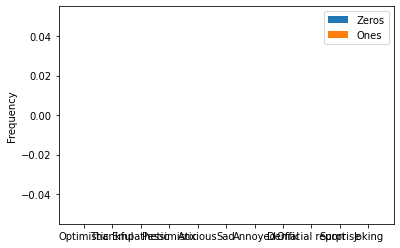

<Figure size 1008x1008 with 0 Axes>

In [ ]:
values = []
for col in req.columns[4:]:
    values.append([req[col].value_counts()[0], req[col].value_counts()[1]])

labels = req.columns[4:]
x = np.arange(len(labels))
width = 0.35

zero_means = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
one_means = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

fig, ax = plt.subplots()
plt.figure(figsize = (14, 14))
rects1 = ax.bar(x - width/2, zero_means, width, label = 'Zeros')
rects2 = ax.bar(x + width/2, one_means, width, label = 'Ones') 

ax.set_ylabel('Frequency')
#ax.set_title('')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

In [ ]:
values

[[25146, 8337],
 [31971, 1512],
 [32876, 607],
 [33017, 466],
 [32275, 1208],
 [32012, 1471],
 [25020, 8463],
 [32924, 559],
 [29640, 3843],
 [28898, 4585],
 [22614, 10869]]

In [ ]:
plt.subplots?